In [2]:
import numpy as np
import scipy.io
import os
import json
import xmltodict
import h5py
import requests

In [42]:
MIN_FRAMES = 400
FRAMES_TRAIN = 400
FRAMES_TEST = 100
PKT_LEN = 400

ROOT_DIR = '/Users/stepanmazokha/Desktop/orbit_frames_rffi_dataset'
# NODE_DIR = '/training_2024-07-13_06-53-20'

# NODE_DIR = '/epoch_2024-07-13_07-40-21'
# NODE_DIR = '/epoch_2024-07-13_07-52-31'
# NODE_DIR = '/epoch_2024-07-13_08-03-18'
# NODE_DIR = '/epoch_2024-07-13_08-14-13'
# NODE_DIR = '/epoch_2024-07-13_08-27-13'
# NODE_DIR = '/epoch_2024-07-13_08-38-59'
# NODE_DIR = '/epoch_2024-07-13_08-51-04'
# NODE_DIR = '/epoch_2024-07-13_09-02-07'
# NODE_DIR = '/epoch_2024-07-13_09-17-04'
NODE_DIR = '/epoch_2024-07-13_09-31-48'

DIR_SOURCE = ROOT_DIR + NODE_DIR + '/equalized_packets/'
FILE_TARGET_NON_EQ_TRAIN = ROOT_DIR + NODE_DIR +'/node1-1_non_eq_train.h5'
FILE_TARGET_EQ_TRAIN = ROOT_DIR + NODE_DIR + '/node1-1_eq_train.h5'
FILE_TARGET_NON_EQ_TEST = ROOT_DIR + NODE_DIR + '/node1-1_non_eq_test.h5'
FILE_TARGET_EQ_TEST = ROOT_DIR + NODE_DIR + '/node1-1_eq_test.h5'
ORBIT_DEVICE_INFO = ROOT_DIR + '/orbit_device_info.json'

In [11]:
def generate_node_ids():
    # This method generates static and unique numeral IDs for each nodes in the Orbit grid
    # This is necessary to ensure correct labeling for TX frames across various datasets
    ids = {}
    node_i = 0
    for i in np.arange(1, 21):
        for j in np.arange(1, 21):
            ids[str(i) + "-" + str(j)] = node_i
            node_i = node_i + 1
    return ids

ALL_NODE_DICT = generate_node_ids()

In [12]:
def get_dataset_nodes(dir_source):
    # Retrieves a list of node names which we have ready for H5 packaging
    return [fname[8:-4] for fname in os.listdir(dir_source)]

def get_orbit_node_capabilities(node_id, show = False):
    url = f"https://www.orbit-lab.org/cPanel/status/getNodeCapabilities?node=node{node_id}.grid.orbit-lab.org"
    headers = {
        # TODO
    }

    response = requests.get(url, headers=headers)

    try:
        if response.status_code == 200:
            responseJson = xmltodict.parse(response.text)
            if responseJson['response']['@status'] != "OK":
                print('Device not found')
                return None
            if show: 
                print(json.dumps(responseJson, indent=4))
            return responseJson
        else: return None
    except:
        print(response.text)
        return None

def save_dict_to_json_file(dictionary, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(dictionary, json_file, indent=4)

def read_json_file_to_dict(file_path):
    with open(file_path, 'r') as json_file:
        dictionary = json.load(json_file)
    return dictionary

def contains_allowed_substring(input_string, allowed_substrings):
    for substring in allowed_substrings:
        if substring in input_string: return True
    return False

def get_orbit_node_infos(node_list, file_path):
    node_infos = {}

    for node_id in node_list:
        print("Processing", node_id)
        node_info = get_orbit_node_capabilities(node_id)

        if node_info is None:
            print(node_id, ': nothing found')
        else:
            devices = node_infos[node_id] = node_info['response']['action']['devices']
            if devices: node_infos[node_id] = devices['device']
        
    save_dict_to_json_file(node_infos, file_path)

def filter_nodes_by_device_model(dir_node_list, node_infos):
    # Paper mentions that they were using Atheros 5212, 9220, 9280, and 9580 WiFi cards
    # We need to find the largest number of nodes (for which we have sufficient data)
    # with ONE of these cards on board (remember: we need the same hardware vendor for 
    # better model performance)
    #
    # After some experimentation, turns out that 5212 card is most common (47 devices w 500 frame limit)
    #
    # Additionally, card 5212 has one device. 
    # 
    # Also, uniqueness of the vendor/model can be identified using the @INV_dev_id field.

    device_types_allowed = ['5212']

    node_list_filtered = []
    for node_id in node_infos:
        if not dir_node_list.__contains__(node_id):
            print('Such node is not present in the directory.')
            continue

        node_info = node_infos[node_id]

        node_fit_devices = 0
        for device in node_info:
            device_type = device.get("@INV_dev_type")
            device_id = device.get('@INV_dev_id')
            device_name = device.get('@name')
        
            if device_type and contains_allowed_substring(device_type, device_types_allowed):
                print('[', device_id, ']:', node_id, ':', device_name, '(', device_type, ')')
                node_fit_devices = node_fit_devices + 1

        if node_fit_devices == 0:
            print(node_id, ':', '5212 NOTHING FOUND')
        elif node_fit_devices >= 1:
            node_list_filtered.append(node_id)

    print('Nodes with Atheros 5212 WiFi card found:', len(node_list_filtered))

    return node_list_filtered

# Retrieve node info for all known nodes and save as a JSON
# get_orbit_node_infos(ALL_NODE_DICT, file_path=ORBIT_DEVICE_INFO)

dir_node_list = get_dataset_nodes(DIR_SOURCE)
node_infos = read_json_file_to_dict(file_path=ORBIT_DEVICE_INFO)
node_list_filtered = filter_nodes_by_device_model(dir_node_list, node_infos)

Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node i

In [20]:
dir_node_list = ['5-1', '7-10', '7-14', '2-19', '5-5', '19-1', '20-20',
 '1-10', '8-20', '11-17', '2-6', '1-12', '4-1', '3-13', '1-16', '8-8', '8-18', '1-19',
 '1-18', '11-7', '20-12', '4-10', '11-4', '8-3', '4-11', '3-18', '14-7', '10-17', '10-11'] # training
####
'12-20', '17-11', '20-19', '20-1', '20-15', '14-10', '16-16', '15-1', '14-7', '16-1'] # testing
node_list_filtered = filter_nodes_by_device_model(dir_node_list, node_infos)

Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
[ 168C:0013 ]: 1-10 : node1-10.grid.orbit-lab.org_dev_3 ( AR5212/5213/2414 Wireless Network Adapter [168C:13] )
Such node is not present in the directory.
[ 168C:0013 ]: 1-12 : node1-12.grid.orbit-lab.org_dev_3 ( AR5212/5213/2414 Wireless Network Adapter [168C:13] )
Such node is not present in the directory.
Such node is not present in the directory.
Such node is not present in the directory.
[ 168C:0013 ]: 1-16 : node1-16.grid.orbit-lab.org_dev_3 ( AR5212/5213/2414 Wireless Network Adapter [168C:13] )
Such node is not present in the directory.
[ 168C:0013 ]: 1-18 : node1-18.grid.orbit-lab.org_dev_4 ( AR52

['1-10',
 '1-12',
 '1-16',
 '1-18',
 '1-19',
 '2-6',
 '2-19',
 '3-13',
 '3-18',
 '4-1',
 '4-10',
 '4-11',
 '5-1',
 '5-5',
 '7-10',
 '7-14',
 '8-3',
 '8-8',
 '8-18',
 '8-20',
 '10-11',
 '10-17',
 '11-4',
 '11-7',
 '11-17',
 '12-20',
 '14-7',
 '14-10',
 '15-1',
 '16-1']

In [18]:
node_list_filtered

['5-1']

In [43]:
def save_dataset_h5(file_target, label, data):
    print('Saving', file_target)
    with h5py.File(file_target, 'w') as h5file:
        h5file.create_dataset('label', data=label, dtype='float64')
        h5file.create_dataset('data', data=data, dtype='float64')        

def package_dataset_h5(node_names, dir_source, frame_count, sample_count, id_filter):
    if id_filter:
        L = len(id_filter)
    else: L = len(node_names)

    h5data_non_eq = np.zeros((L * frame_count, sample_count * 2), dtype='float64')
    h5data_eq = np.zeros((L * frame_count, sample_count * 2), dtype='float64')
    h5labels = np.zeros((L * frame_count, 1), dtype='float64')

    print(h5labels.shape)

    h5_idx = 0
    for node_idx in np.arange(len(node_names)):
        node_name = node_names[node_idx]
        node_id = ALL_NODE_DICT[node_name]

        if id_filter and node_id not in id_filter:
            print("Node", node_name, "isn't in the allowed set of devices.")
            continue

        print("Processing", node_name)

        f = scipy.io.loadmat(dir_source + 'packets_node' + node_name, verify_compressed_data_integrity=False)
        
        # Retrieve the list of frames; each item is a cell, containing two vectors: non-eq & eq IQ samples
        frames = f['packet_log'][0]

        if len(frames) < frame_count:
            print('Not enough frames for ', node_name)
            continue

        for frame_idx in np.arange(frame_count):
            iq_non_eq = frames[frame_idx][0:frame_count, 0] # non-equalized
            iq_eq = frames[frame_idx][0:frame_count, 1] # equalized

            h5data_non_eq[h5_idx, 0::2] = np.real(iq_non_eq)
            h5data_non_eq[h5_idx, 1::2] = np.imag(iq_non_eq)

            h5data_eq[h5_idx, 0::2] = np.real(iq_eq)
            h5data_eq[h5_idx, 1::2] = np.imag(iq_eq)

            h5labels[h5_idx] = ALL_NODE_DICT[node_name]
            
            h5_idx = h5_idx + 1

    return [h5data_non_eq, h5data_eq, h5labels]

def process_save_rx(node_list_filtered, dir_source, frame_count, sample_count, file_target_non_eq_train, file_target_eq_train, file_target_non_eq_class, file_target_eq_class):
    # nodes_train = node_list_filtered[0:30] # use first 30 devices for training the model
    # nodes_class = node_list_filtered[30:] # use second 30 devices for testing the model

    nodes_train = ['5-1', '7-10', '7-14', '2-19', '5-5', '19-1', '20-20',
        '1-10', '8-20', '11-17', '2-6', '1-12', '4-1', '3-13', '1-16', '8-8', '8-18', '1-19',
        '1-18', '11-7', '20-12', '4-10', '11-4', '8-3', '4-11', '3-18', '14-7', '10-17', '10-11']
    nodes_class = ['12-20', '17-11', '20-19', '20-1', '20-15', '14-10', '16-16', '15-1', '14-7', '16-1']

    # class_unit_ids = [391, 360, 329, 266, 330, 300, 269, 394, 239, 398, 242, 280, 378, 315, 380]

    # [h5data_non_eq_train, h5data_eq_train, h5labels_train] = package_dataset_h5(nodes_train, dir_source, frame_count, sample_count, None)
    [h5data_non_eq_class, h5data_eq_class, h5labels_class] = package_dataset_h5(nodes_class, dir_source, frame_count, sample_count, None)

    # Save to H5
    # save_dataset_h5(file_target=file_target_non_eq_train, label=h5labels_train, data=h5data_non_eq_train)
    # save_dataset_h5(file_target=file_target_eq_train, label=h5labels_train, data=h5data_eq_train)

    save_dataset_h5(file_target=file_target_non_eq_class, label=h5labels_class, data=h5data_non_eq_class)
    save_dataset_h5(file_target=file_target_eq_class, label=h5labels_class, data=h5data_eq_class)

process_save_rx(node_list_filtered, DIR_SOURCE, MIN_FRAMES, PKT_LEN, FILE_TARGET_NON_EQ_TRAIN, FILE_TARGET_EQ_TRAIN, FILE_TARGET_NON_EQ_TEST, FILE_TARGET_EQ_TEST)

(4000, 1)
Processing 12-20
Processing 17-11
Processing 20-19
Processing 20-1
Processing 20-15
Processing 14-10
Processing 16-16
Processing 15-1
Processing 14-7
Processing 16-1
Saving /Users/stepanmazokha/Desktop/orbit_frames_rffi_dataset/epoch_2024-07-13_09-31-48/node1-1_non_eq_test.h5
Saving /Users/stepanmazokha/Desktop/orbit_frames_rffi_dataset/epoch_2024-07-13_09-31-48/node1-1_eq_test.h5


In [72]:
def read_dataset_h5(file_target, dataset_name):
    with h5py.File(file_target, 'r') as h5file:
        dataset = h5file[dataset_name][:]
    return dataset

read_dataset_h5(FILE_TARGET_EQ_TEST, 'data').shape

(10000, 800)

In [73]:
def image_size_calc(L, N):
    # In STFT, with 50% overlap, we've got the following formula to determine size of the image:
    # L = N + (N/2) * (M-1), where:
    # - L: # of samples in the preamble (Shen had 8192)
    # - N: nfft (Shen had it as 256)
    # - M: # of windows
    # Therefore, to estimate M we'll have the formula: 
    # M = 1 + (2/N) * (L - N)
    return int(1 + (2/N) * (L - N))

image_size_calc(8192, 256)

63

In [55]:
def get_node_names_file(path1):
    with h5py.File(path1, 'r') as h5file1:
        label = h5file1['label'][:]

    items = ["" for x in range(len(ALL_NODE_DICT.keys()))]

    for key in ALL_NODE_DICT.keys():
        value = ALL_NODE_DICT[key]
        items[value] = key

    unique = list(set(label.flatten()))


    node_names = []

    for l in unique:
        node_names.append(str(items[int(l)]))

    return node_names

train_names = get_node_names_file('/Users/stepanmazokha/Desktop/wisig_frames_rffi_dataset/node1-1_wifi_2021_03_01/node1-1_eq_train.h5')
test_names = get_node_names_file('/Users/stepanmazokha/Desktop/wisig_frames_rffi_dataset/node1-1_wifi_2021_03_01/node1-1_eq_test.h5')


node_infos[train_names[0]]


[{'@INV_dev_id': '8086:1502',
  '@INV_dev_type': '82579LM Gigabit Network Connection [8086:1502]',
  '@INV_if_mac': '00:03:1d:0c:7d:d0',
  '@INV_if_name': 'eth0',
  '@name': 'node7-10.grid.orbit-lab.org_dev_0',
  '@status': 'OK',
  '@type': 'device'},
 {'@INV_dev_id': '8086:10D3',
  '@INV_dev_type': '82574L Gigabit Network Connection [8086:10D3]',
  '@INV_if_mac': '00:03:1d:0c:7d:d1',
  '@INV_if_name': 'eth1',
  '@name': 'node7-10.grid.orbit-lab.org_dev_1',
  '@status': 'OK',
  '@type': 'device'},
 {'@INV_dev_id': '168C:002A',
  '@INV_dev_type': 'AR928X Wireless Network Adapter (PCI-Express) [168C:2A]',
  '@INV_if_mac': 'N/A',
  '@INV_if_name': 'N/A',
  '@name': 'node7-10.grid.orbit-lab.org_dev_2',
  '@status': 'OK',
  '@type': 'device'},
 {'@INV_dev_id': '168C:0013',
  '@INV_dev_type': 'AR5212/5213/2414 Wireless Network Adapter [168C:13]',
  '@INV_if_mac': 'N/A',
  '@INV_if_name': 'N/A',
  '@name': 'node7-10.grid.orbit-lab.org_dev_3',
  '@status': 'OK',
  '@type': 'device'},
 {'@INV_d

In [102]:
path1 = '/Users/stepanmazokha/Desktop/wisig_frames_rffi_dataset/node1-1_wifi_2021_03_01/node1-1_eq_test.h5'
path2 = '/Users/stepanmazokha/Desktop/wisig_frames_rffi_dataset/node1-1_wifi_2021_03_08/node1-1_eq_test.h5'

label1 = []
label2 = []
with h5py.File(path1, 'r') as h5file1:
    label1 = h5file1['label'][:]

with h5py.File(path2, 'r') as h5file2:
    label2 = h5file2['label'][:]

l1 = set(label1.flatten())
l2 = set(label2.flatten())

common_test_units = l1.intersection(l2)

print(common_test_units)

# for unit in common_test_units:
    # print(int(unit))

{391.0, 360.0, 329.0, 266.0, 330.0, 300.0, 269.0, 394.0, 239.0, 398.0, 242.0, 280.0, 378.0, 315.0, 380.0}


In [103]:
for i in l1:
    print(i)

391.0
360.0
329.0
266.0
330.0
300.0
269.0
394.0
239.0
398.0
242.0
280.0
378.0
315.0
380.0


<Axes: >

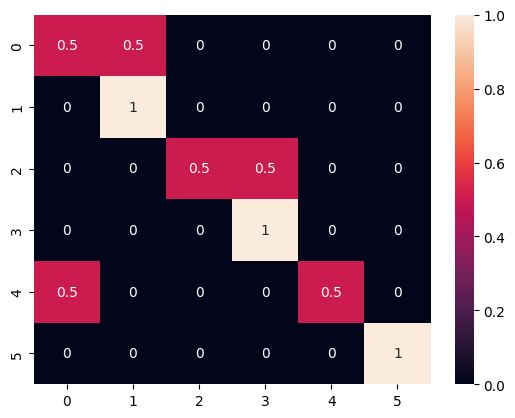

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sea

val_true = [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
val_pred = [2, 1, 2, 2, 4, 3, 4, 4, 5, 1, 6, 6]

matrix = confusion_matrix(val_true, val_pred, normalize='true')

sea.heatmap(matrix, annot=True)